In [1]:
%matplotlib inline

import xarray as xr
import intake
import util 
import pprint 
import dask
import gsw
import matplotlib.pyplot as plt
import numpy as np

# specific plotting stuff from Lettie
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util
import xesmf as xe
from cmip6_preprocessing.preprocessing import read_data

nm = 12

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
def get_dictionary():
    """
    Function to get the dictionary of models and ensemble members of the historical runs 
    that have all of siconc, so, and thetao
    
    Returns the dictionary, the appropriate intake-esm catalog and the list of models needed to pass
    to the next function that gets the datasets.
    """
    
    print('opening intake-esm catalog...')
    url = "https://raw.githubusercontent.com/andrewpauling/cmip6hack-so-project/master/catalogs/pangeo-cmip6.json"
    col = intake.open_esm_datastore(url)
    print('done')
    
    cat = col.search(experiment_id=['historical'], table_id=['SImon', 'Omon'],
                 grid_label='gn')
    
    uni_dict = cat.unique(['source_id', 'experiment_id', 'table_id', 'member_id'])
    
    cat = col.search(experiment_id=['historical'], table_id=['SImon', 'Omon'],
                 grid_label='gn', variable_id=['siconc', 'thetao', 'so'])
    
    print('Find the models that have all three variables...')
    models = set(uni_dict['source_id']['values']) # all the models

    for table_id in ['SImon', 'Omon']:
        if table_id == 'SImon':
            query = dict(experiment_id='historical', table_id=table_id, 
                         variable_id='siconc', grid_label='gn')  
            cat = col.search(**query)
            models = models.intersection({model for model in cat.df.source_id.unique().tolist()})
        else:
            for variable_id in ['thetao', 'so']:
                query = dict(experiment_id='historical', table_id=table_id, 
                             variable_id=variable_id, grid_label='gn')  
                cat = col.search(**query)
                models = models.intersection({model for model in cat.df.source_id.unique().tolist()})
                
    models = list(models)
    print('Done')
    
    cat = col.search(experiment_id='historical', table_id=['Omon', 'SImon'], 
                 variable_id=['siconc', 'thetao', 'so'], grid_label='gn', source_id=models)
    
    print('Make sure all three variables have the same ensemble member...')
    filt_dict = dict()

    for model in models:
        tmp2 = cat.search(source_id=model)
        tmp2.df.head()
        members = tmp2.df['member_id']
        memlist = list()
        for member in list(members):
            a = tmp2.search(member_id=member, variable_id='siconc').df['activity_id'].empty
            b = tmp2.search(member_id=member, variable_id='thetao').df['activity_id'].empty
            c = tmp2.search(member_id=member, variable_id='so').df['activity_id'].empty
            if not a and not b and not c and member not in memlist:
                memlist.append(member)
        filt_dict[model] =  memlist
        
    print('Done')
    
    return filt_dict, cat, models

In [3]:
def get_datasets(filt_dict, cat, models):
    """
    Function to load the dataset dictionaries for each of the variables siconc, so, thetao. Takes in the output
    of get_dictionary()
    Returns the dataset dictonary for each variable. Separate one for each variable due to problems with intake-esm 
    for some models
    """
        
    icedict = dict()
    sodict = dict()
    thetaodict = dict()
    for model in models:
        print(model)
        tmpice = cat.search(source_id=model, member_id=filt_dict[model], variable_id='siconc')
        tmpdict_ice = tmpice.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                             cdf_kwargs={'chunks': {}, 'decode_times': False})
        icedict.update(tmpdict_ice)
        tmpice = None
        tmpdictice = None
    
        tmpso = cat.search(source_id=model, member_id=filt_dict[model], variable_id='so')
        tmpdict_so = tmpso.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                           cdf_kwargs={'chunks': {}, 'decode_times': False})
        sodict.update(tmpdict_so)
        tmpso = None
        tmpdictso = None
    
        tmpthetao = cat.search(source_id=model, member_id=filt_dict[model], variable_id='thetao')
        tmpdict_thetao = tmpthetao.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                                   cdf_kwargs={'chunks': {}, 'decode_times': False})
        thetaodict.update(tmpdict_thetao)
        tmpthetao = None
        tmpdictthetao = None
    
    return icedict, sodict, thetaodict

In [4]:
# skip this cell if the kernel restarts and go two cells down ...

# [filt_dict, cat, models] = get_dictionary()

opening intake-esm catalog...
done
Find the models that have all three variables...
Done
Make sure all three variables have the same ensemble member...
Done


In [4]:
import pickle 

#pickle.dump( [filt_dict, cat, models] , open( "save.p", "wb" ) ) 

In [5]:
# if the kernel restarts, come here after skipping the one two cells above and run the notebook from this cell

[filt_dict, cat, models] = pickle.load( open( "save.p", "rb" ) )

In [6]:
# filt_dict, cat, models = get_dictionary()
icedict, sodict, thetaodict = get_datasets(filt_dict, cat, models)

UKESM1-0-LL
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
GFDL-CM4
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 10 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 10 group(s)
--> The keys in the returned dictionary of datasets are c

In [7]:
ops = sodict.keys()

In [8]:
# one model has inconsistencies b/w time grid so remove it
sodict.pop('CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn')
thetaodict.pop('CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn')
icedict.pop('CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn')

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 200, member_id: 1, time: 1980, vertices: 4)
Coordinates:
  * j                   (j) int32 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * time                (time) float64 15.5 45.0 74.5 ... 6.018e+04 6.021e+04
  * member_id           (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    latitude            (j, i) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    type                |S7 ...
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(200, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(200, 360, 4), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    time_bnds           (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    siconc           

In [9]:
from cmip6_preprocessing.preprocessing import rename_cmip6
thetaodict.keys()
threekeys= ['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn',
            'CMIP.CCCma.CanESM5.historical.Omon.gn', 
            'CMIP.MOHC.HadGEM3-GC31-LL.historical.Omon.gn']

In [10]:
thetaodict_small={}
sodict_small ={}
# rename all variables to be the same 
for i in threekeys:
    thetaodict_small[i] = rename_cmip6(thetaodict[i])

for i in threekeys:
    sodict_small[i] = rename_cmip6(sodict[i]) 

/srv/conda/envs/notebook/lib/python3.7/site-packages/cmip6_preprocessing-0+untagged.5.g1b9d6ba-py3.7.egg/cmip6_preprocessing/preprocessing.py:129: UserWarning: Variable [lev_bounds] not found in Coordinates:
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * bnds       (bnds) float64 1.0 2.0
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
  * member_id  (member_id) <U8 'r1i1p1f1'
/srv/conda/envs/notebook/lib/python3.7/site-packages/cmip6_preprocessing-0+untagged.5.g1b9d6ba-py3.7.egg/cmip6_preprocessing/preprocessing.py:129: UserWarning: Variable [lev_bounds] not found in Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * y          (y) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
  * lev        (lev) float64 3.0

In [11]:
# start the process of estimating the densities. 
deriveddict= {}

for i in sodict_small:
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, sodict_small[i].so, thetaodict_small[i].thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    deriveddict[i] = cthetao

In [12]:
for i in deriveddict:    
    pdens=xr.apply_ufunc(gsw.density.sigma2,sodict_small[i].so, deriveddict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('pdens').to_dataset()
    
    pdens0=xr.apply_ufunc(gsw.density.sigma0,sodict_small[i].so, deriveddict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('pdens0').to_dataset()
    deriveddict[i] = xr.merge([pdens, pdens0, deriveddict[i]])

In [19]:
deriveddict[i]

<xarray.Dataset>
Dimensions:    (lev: 75, member_id: 1, time: 1980, x: 360, y: 330)
Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * y          (y) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time       (time) int64 0 30 60 90 120 150 ... 59250 59280 59310 59340 59370
  * member_id  (member_id) <U8 'r2i1p1f3'
Data variables:
    pdens      (member_id, time, lev, y, x) float64 dask.array<chunksize=(1, 12, 75, 330, 360), meta=np.ndarray>
    pdens0     (member_id, time, lev, y, x) float64 dask.array<chunksize=(1, 12, 75, 330, 360), meta=np.ndarray>
    cthetao    (member_id, time, lev, y, x) float64 dask.array<chunksize=(1, 12, 75, 330, 360), meta=np.ndarray>

In [20]:
bottom_props = {}

for (n,i) in enumerate(deriveddict):
    print(thetaodict[i].attrs['source_id'])
    
    ds = deriveddict[i].isel(time=7, member_id=-1)
    dstemp = thetaodict_small[i].isel(time=7, member_id=-1)
    dssalt = sodict_small[i].isel(time=7, member_id=-1)
    
    temp = ds.pdens + ds.lev
    
    bottom_dens = ds.pdens.where(temp==temp.max(['lev'])).max(['lev'])
    bottom_temp = dstemp.thetao.where(temp==temp.max(['lev'])).max(['lev'])
    bottom_salt = dssalt.so.where(temp==temp.max(['lev'])).max(['lev'])
    topo = (temp- ds.pdens).max(['lev']).rename('topo')
    
    # interpolate density data
    surf_dens = ds.pdens0.interp(lev=10)
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = ds.pdens0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev']).rename('mld')
    # ratio of mld to total depth
    relative_depth = mld/topo
    relative_depth = relative_depth.rename('rel_depth')
    
    bottom_props[i] = xr.merge([bottom_dens, bottom_temp, bottom_salt, topo, mld, relative_depth])

bottom_props

GFDL-CM4
CanESM5
HadGEM3-GC31-LL


{'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (x: 1440, y: 1080)
 Coordinates:
   * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
   * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
     time       int64 5088
     member_id  <U8 'r1i1p1f1'
 Data variables:
     pdens      (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     thetao     (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     so         (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     topo       (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     mld        (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     rel_depth  (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>,
 'CMIP.CCCma.CanESM5.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (x: 360, y: 291)
 Coordinates:
   * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 352

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


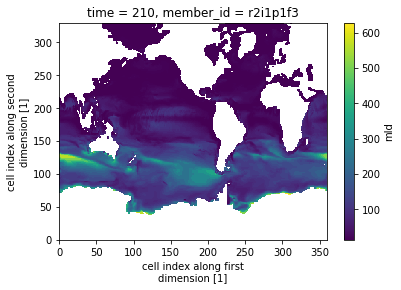

In [21]:
bottom_props[i].mld.plot()

In [22]:
bottom_props.keys()

dict_keys(['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn', 'CMIP.CCCma.CanESM5.historical.Omon.gn', 'CMIP.MOHC.HadGEM3-GC31-LL.historical.Omon.gn'])

In [26]:
bottom_props

{'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (x: 1440, y: 1080)
 Coordinates:
   * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
   * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
     time       int64 5088
     member_id  <U8 'r1i1p1f1'
 Data variables:
     pdens      (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     thetao     (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     so         (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     topo       (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     mld        (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     rel_depth  (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>,
 'CMIP.CCCma.CanESM5.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (x: 360, y: 291)
 Coordinates:
   * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 352

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/c

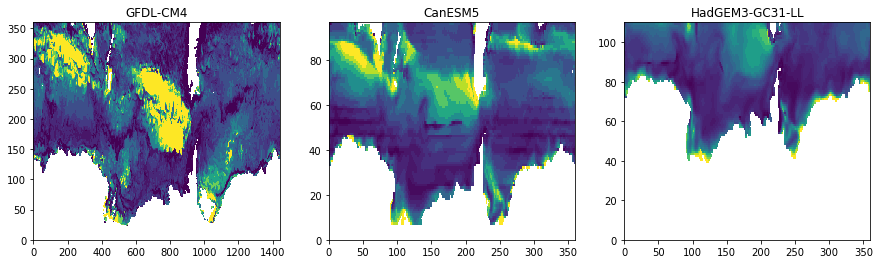

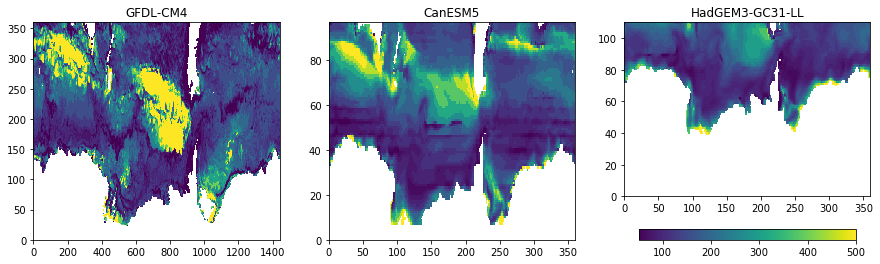

In [32]:
fig = plt.figure(figsize=(15,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1)#,projection = ccrs.SouthPolarStereo())
    #ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    
    #ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    #im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].mld.isel(member_id=-1),
    #              transform=ccrs.PlateCarree(), vmin=2000, vmax=6000)
    
    im = ax.pcolormesh(bottom_props[i].mld,
                 vmin=50, vmax = 500)
    
   # if n ==2:
       
    #    fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    ax.set_ylim([0, len(bottom_props[i].y)/3])
    
    ax.set_title(ds.attrs['source_id'])
    
fig = plt.figure(figsize=(15,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1)#,projection = ccrs.SouthPolarStereo())
    #ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    
    #ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    #im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].mld.isel(member_id=-1),
    #              transform=ccrs.PlateCarree(), vmin=2000, vmax=6000)
    
    im = ax.pcolormesh(bottom_props[i].mld,
                 vmin=50, vmax = 500)
    
    if n ==2:
       
        fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    ax.set_ylim([0, len(bottom_props[i].y)/3])
    
    ax.set_title(ds.attrs['source_id'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/c

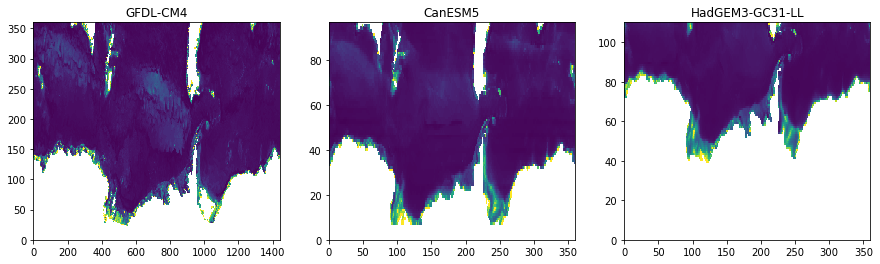

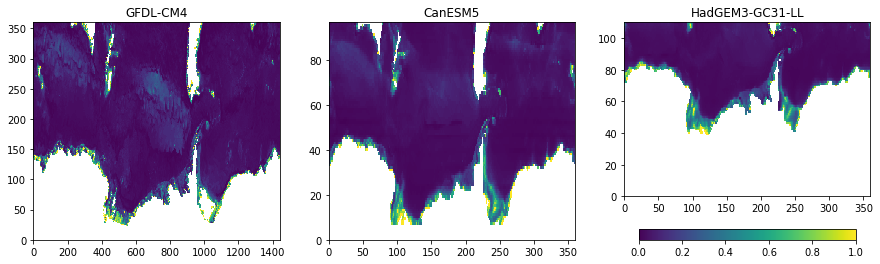

In [33]:
fig = plt.figure(figsize=(15,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1)#,projection = ccrs.SouthPolarStereo())
    #ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    
    #ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    #im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].rel_depth.isel(member_id=-1),
    #              transform=ccrs.PlateCarree(), vmin=2000, vmax=6000)
    
    im = ax.pcolormesh(bottom_props[i].rel_depth,
                 vmin=0, vmax = 1)
    
#     if n ==2:
       
#         fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    ax.set_ylim([0, len(bottom_props[i].y)/3])
    
    ax.set_title(ds.attrs['source_id'])
fig = plt.figure(figsize=(15,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1)#,projection = ccrs.SouthPolarStereo())
    #ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    
    #ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    #im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].rel_depth.isel(member_id=-1),
    #              transform=ccrs.PlateCarree(), vmin=2000, vmax=6000)
    
    im = ax.pcolormesh(bottom_props[i].rel_depth,
                 vmin=0, vmax = 1)
    
    if n ==2:
       
        fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    ax.set_ylim([0, len(bottom_props[i].y)/3])
    
    ax.set_title(ds.attrs['source_id'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


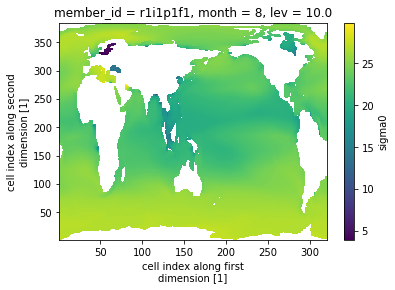

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


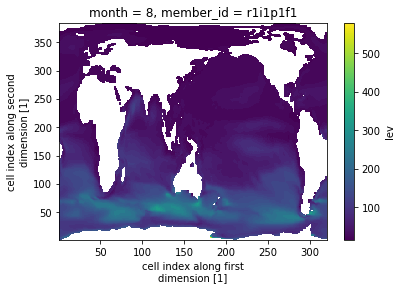

<xarray.DataArray 'relative_depth' (member_id: 1, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(1, 384, 320), dtype=float64, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
    month      int64 8


In [10]:
# need to find index of depth or lev that is closest to 10m. If units are in centimeters, convert to meters
for i in dset_dict:
    if 'depth' in dset_dict[i]:
        dset_dict[i].depth = xr.Dataset.rename({'depth':'lev'})
    if dset_dict[i].lev.units == 'centimeters':
        dset_dict[i].lev.values = dset_dict[i].lev.values/100
        dset_dict[i].lev.attrs['units'] = 'm'
    
# big mamma loop-de-loop

for i in dset_dict:
    dset_dict[i]= dset_dict[i].sel(time=slice('1986','2005')).groupby('time.month').mean().sel(month=8)
    
    # calculate cthetao and add to ds
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, dset_dict[i].so, dset_dict[i].thetao, dask='parallelized',
                                         output_dtypes=[float,]).rename('cthetao').to_dataset()     
    dset_dict[i] = xr.merge([dset_dict[i],cthetao])
    
    # calculate sigma0 and add to ds
    sigma0 = xr.apply_ufunc(gsw.density.sigma0,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()                                                                          
    dset_dict[i] = xr.merge([dset_dict[i],sigma0])
    
    # calculate sigma2 and add to ds
    sigma2=xr.apply_ufunc(gsw.density.sigma2,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    dset_dict[i] = xr.merge([sigma2, dset_dict[i]])
    
    
    # interpolate density data
    dsi = dset_dict[i].sigma0.interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 10)
    surf_dens.plot(); plt.show(); plt.close()
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = dset_dict[i].sigma0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])    
    # plot for sanity check
    mld.plot(); plt.show(); plt.close()
        
    # get variables at bottom
    test = dset_dict[i].sigma0 + dset_dict[i].lev
    bottom_depth = dset_dict[i].lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_sigma2 = dset_dict[i].sigma2.where(test == test.max(['lev'])).max(dim='lev')
    bottom_temp = dset_dict[i].thetao.where(test == test.max(['lev'])).max(dim='lev')
    dset_dict[i]['bottom_depth'] = bottom_depth
    dset_dict[i]['bottom_sigma2'] = bottom_sigma2
    dset_dict[i]['bottom_temp'] = bottom_temp
    
    # ratio of mld to total depth
    dset_dict[i]['relative_depth'] = mld/bottom_depth
    print(dset_dict[i].relative_depth)
    

0
Reuse existing file: nearest_s2d_384x320_361x161_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/si

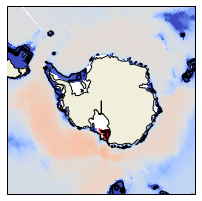

In [11]:
# Now let's try plotting:

# New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
# concentration for the contour plot (otherwise the contour will reverse on itself)
res_new = 1 #degrees; the resolution of the new grid
lat_new = -80 + np.arange(1+(2*80)/res_new) # only go from 80S to 80N
lon_new = np.arange(1+(360)/res_new)
lon_new, lat_new = np.meshgrid(lon_new,lat_new)

index = 0 # dummy index
fig = plt.figure(figsize=(20,20))
for i in dset_dict:
    print(index) # to make sure the calculation hasn't stalled
    
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in dset_dict[i]:
        latitude = dset_dict[i].latitude
        longitude = dset_dict[i].longitude
    elif 'lat' in dset_dict[i]:
        latitude = dset_dict[i].lat
        longitude = dset_dict[i].lon
    else:
        latitude = dset_dict[i].nav_lat
        longitude = dset_dict[i].nav_lon
        
    # Deal with multiple ensemble members, 1D grid vectors
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    # Load in the bottom potential density and find its size
    data = dset_dict[i].bottom_sigma2.squeeze()
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)
    
    # Regrid
    data_new = data
    lat_temp = latitude.copy()
    lon_temp = longitude.copy()
    method = np.str('nearest_s2d')
    # Make method exceptions for models with weird grids around antarctica
#     if dset_dict[i].source_id == 'CNRM-CM6-1':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'CNRM-ESM2-1':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'EC-Earth3':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'EC-Earth3-Veg':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'IPSL-CM6A-LR':
#         method = np.str('nearest_s2d')
    # Make sure the dimensions of the new grid are in the right order
    lat_temp = lat_new.copy()
    lon_temp = lon_new.copy()
    if ndim0>ndim1:
        lat_temp = np.transpose(lat_temp)
        lon_temp = np.transpose(lon_temp)
    lat_temp2 = latitude.copy()
    lon_temp2 = longitude.copy()
    lat_temp2[np.abs(lat_temp2)>90] = np.nan
    lon_temp2[np.abs(lon_temp2)>360] = np.nan
    # Create the xarray datasets to feed into the xesmf regridder
    ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                        'lon': (['x','y'],lon_temp2)})
    ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                            'lon': (['x','y'],lon_temp)})
    # Regrid the data
    f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
    data_new = f(data)
    threshold_new = f(dset_dict[i].relative_depth.squeeze())
    
    # A data mask for SouthPolarStereo plots
    mydata = ma.masked_where(latitude>0.,data.copy())
    mydata_new = ma.masked_where(lat_temp>0.,data_new.copy())
    
    # Make a pcolor plot of bottom potential density, and contour the >50% mld/total depth threshold
    ax = plt.subplot(5,4,index+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.coolwarm, vmin=36.8, vmax=37.2)
    this2 = ax.contour(lon_temp,lat_temp,threshold_new,transform=ccrs.PlateCarree(),colors='k')
#     plt.title(np.str(dset_dict[i].source_id))
    
    index = index+1

In [13]:
# area of deep convection (mld/total depth > 50) off the shelf (where lev > 1500 m)
# print(dset_dict[i].relative_depth)
# print(dset_dict[i].bottom_depth)

for i in dset_dict:
    deep_convect = dset_dict[i].relative_depth.where(dset_dict[i].bottom_depth > 1500)
    dset_dict[i]['deep_convect'] = deep_convect

print(dset_dict[i].deep_convect)

# area stuff
a = 6.37E6 # m; the radius of the Earth
res_new = 1 #degrees; the resolution of the new grid
lat_new = -80 + res_new/2 + np.arange(2*80/res_new) # only go from 80S to 80N
latf_new = -80 + np.arange(1+(2*80)/res_new)
lon_new = res_new/2 + np.arange(1+(360)/res_new)
lon_new, lat_new = np.meshgrid(lon_new,lat_new)
area_new = (res_new*np.pi/180)*(a**2)*(np.sin(np.pi*latf_new[1:]/180)-np.sin(np.pi*latf_new[:-1]/180))
area_new = np.tile(area_new,(np.int(1+360/res_new),1)).swapaxes(0,1)

# areadc will be the area of each cell that has deep convection off the shelf
for i in dset_dict:
    print(index) # to make sure the calculation hasn't stalled
    
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in dset_dict[i]:
        latitude = dset_dict[i].latitude
        longitude = dset_dict[i].longitude
    elif 'lat' in dset_dict[i]:
        latitude = dset_dict[i].lat
        longitude = dset_dict[i].lon
    else:
        latitude = dset_dict[i].nav_lat
        longitude = dset_dict[i].nav_lon
        
    # Deal with multiple ensemble members, 1D grid vectors
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    # Load in the deep convection and find its size
    data = dset_dict[i].deep_convect.squeeze()
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)
    
    # Regrid
    data_new = data
    lat_temp = latitude.copy()
    lon_temp = longitude.copy()
    method = np.str('nearest_s2d')
    # Make method exceptions for models with weird grids around antarctica
#     if dset_dict[i].source_id == 'CNRM-CM6-1':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'CNRM-ESM2-1':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'EC-Earth3':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'EC-Earth3-Veg':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'IPSL-CM6A-LR':
#         method = np.str('nearest_s2d')
    # Make sure the dimensions of the new grid are in the right order
    lat_temp = lat_new.copy()
    lon_temp = lon_new.copy()
    if ndim0>ndim1:
        lat_temp = np.transpose(lat_temp)
        lon_temp = np.transpose(lon_temp)
    lat_temp2 = latitude.copy()
    lon_temp2 = longitude.copy()
    lat_temp2[np.abs(lat_temp2)>90] = np.nan
    lon_temp2[np.abs(lon_temp2)>360] = np.nan
    # Create the xarray datasets to feed into the xesmf regridder
    ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                        'lon': (['x','y'],lon_temp2)})
    ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                            'lon': (['x','y'],lon_temp)})
    # Regrid the data
    f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
    data_new = f(data)

    area_dc = area_new * data_new.T
    print(area_dc)
    
    int_areadc = np.nansum(area_dc.sel())
    print(int_areadc)

<xarray.DataArray 'deep_convect' (member_id: 1, nlat: 384, nlon: 320)>
dask.array<where, shape=(1, 384, 320), dtype=float64, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
    month      int64 8
1


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:1893: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


Reuse existing file: nearest_s2d_384x320_361x160_peri.nc
<xarray.DataArray 'deep_convect' (y: 160, x: 361)>
dask.array<multiply, shape=(160, 361), dtype=float64, chunksize=(160, 361), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f1'
    month      int64 8
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 360.5 360.5 360.5 360.5
    lat        (x, y) float64 -79.5 -78.5 -77.5 -76.5 ... 76.5 77.5 78.5 79.5
Dimensions without coordinates: y, x


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


7161495306770.989


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [ ]:
print(int_areadc)

In [17]:
print(dset_dict[i])

<xarray.Dataset>
Dimensions:         (d2: 2, lev: 60, member_id: 1, nlat: 384, nlon: 320, vertices: 4)
Coordinates:
  * lev             (lev) float64 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
  * member_id       (member_id) <U8 'r1i1p1f1'
  * nlon            (nlon) int32 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * nlat            (nlat) int32 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
    month           int64 8
Dimensions without coordinates: d2, vertices
Data variables:
    sigma2          (member_id, lev, nlat, nlon) float64 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    lat_bnds        (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds        (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lev_bn